<a href="https://colab.research.google.com/github/jjsalaza/Ingenieria-Logistica-ULL/blob/master/Julia_para_Ingenieria_Logistica_2022_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cuaderno Jupyter en **Julia** para la asignatura **Ingeniería Logística** 2022-2023

La primera celda ejecutable de este cuaderno está intensionadamente escrita para que puedas usar este cuaderno con código [Julia](https://julialang.org/) en cualquier plataforma [Jupyter](https://jupyter.org/), incluída [Google Colab](https://colab.research.google.com/?hl=es). 

Lo primero que debes hacer es trabajar sobre una copia de este cuaderno, para tener siempre la versión original a salvo. Luego debes ejecutar la primera celda para que instale [Julia](https://julialang.org/) y otros paquetes que por defecto no vienen en ningún [Jupyter](https://jupyter.org/). Y posteriormente recargar el cuaderno (pulsa las teclas Ctrl+R , o la tecla F5) para continuar con tu estudio a través de este cuaderno. Lo que habrás hecho es cambiar el Python nativo en todo Jupyter por Julia. ¡¡¡Ya verás las ventajas!!!

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.1"           # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia JuMP GLPK"         
JULIA_PACKAGES_IF_GPU="CUDA"
JULIA_NUM_THREADS=4
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
fi

Unrecognized magic `%%shell`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


La siguiente celda es sólo un comando Julia para que compruebes que ahora Julia funciona. No es importante.

In [ ]:
versioninfo()

Julia Version 1.8.1
Commit afb6c60d69a (2022-09-06 15:09 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 2 × Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, broadwell)
  Threads: 4 on 2 virtual cores
Environment:
  LD_LIBRARY_PATH = /usr/local/nvidia/lib:/usr/local/nvidia/lib64
  LD_PRELOAD = /usr/lib/x86_64-linux-gnu/libtcmalloc.so.4
  JULIA_NUM_THREADS = 4


Antes de entrar de pleno en nuestra asignatura (Ingeniería Logística), quiero enfatizar que Julia no es el objetivo de este curso. Julia es sólo es el lenguaje que usaremos para ilustrar el objetivo del curso, que es "modelización matemática" principalmente. Podíamos haber usado otros lenguajes alternativos, como C/C++ o Java o Python, e incluso otros menos mucho menos generales, especialmente orientados a la modelización matemática, como son MOSEL o AMPL o OPL. El motivo de elegir Julia es que es un lenguaje moderno, versátil, con las ventajas del Python, y con la rapidez del C/C++. ¡¡Espero que te resulte de interés!! 😃

En internet existen muchos manuales para aprender lo básico de Julia. No lo necesitarás. Es muy intuitivo y los ejemplos que iremos estudiando en el curso (siempre orientados a la Modelización Matemática) serán más que suficientes. No obstante, si no aguantas las ansias de conocer Julia, te recomiendo por ejemplo https://hedero.webs.upv.es/julia-basico/

Si ya conoces algo de Python y la plataforma Google Colab, quizás el siguiente cuaderno te ayude mucho: https://colab.research.google.com/github/ageron/julia_notebooks/blob/master/Julia_for_Pythonistas.ipynb

Entre los paquetes que te he instalado está [JuMP](https://jump.dev/JuMP.jl/stable/), que contiene los elementos propios de *Mathematical Programming*, es decir, lo que necesitaremos en el curso para trabajar con modelos matemáticos en Julia.

También te he instalado un paquete con métodos para resolver modelos de Programación Matemática (Optimización). Como librería de optimización me gusta mucho [Gurobi](https://docs.juliahub.com/Gurobi/do9v6/0.7.7/), pero es comercial y exige tener licencia en el entorno alojado o local que uses para las ejecuciones. Entre las librerías no-comerciales destaco [HiGHS](https://highs.dev/), a la que lamentablemente aún le falta un ingrediente utilísimo (*callbacks*). Yo te he instalado la librería no-comercial [GLPK](https://juliapackages.com/p/glpk).

Pongamos a mano los elementos de los paquetes instalados

In [ ]:
using JuMP, GLPK, Random

# Ingeniería Logística



La siguiente celda muestra cómo escribir y resolver un modelo matemático. Es un modelo matemático diminuto e inútil, pero suficiente para evidenciar nuestra capacidad actual para afrontar modelos del tipo $\min\{f(x) : g(x)\leq 0 \}$, donde las variables $x$ representan las decisiones a tomar, las desigualdades $g(\cdot)\leq 0$ representan las limitaciones de recursos, y $f(\cdot)$ representa el objetivo que minimizamos (costes, por ejemplo). 



In [ ]:
model = Model(GLPK.Optimizer)
@variable(model, x >= 0)
@variable(model, 0 <= y <= 3)
@objective(model, Min, 12x + 20y)
@constraint(model, c1, 6x + 8y >= 100)
@constraint(model, c2, 7x + 12y >= 120)
print(model)
optimize!(model)
@show termination_status(model)
@show primal_status(model)
@show dual_status(model)
@show objective_value(model)
@show value(x)
@show value(y)
@show shadow_price(c1)
@show shadow_price(c2)

termination_status(model) = MathOptInterface.OPTIMAL
primal_status(model) = MathOptInterface.FEASIBLE_POINT
dual_status(model) = MathOptInterface.FEASIBLE_POINT
objective_value(model) = 204.99999999999997
value(x) = 15.000000000000005
value(y) = 1.249999999999996
shadow_price(c1) = -0.24999999999999922
shadow_price(c2) = -1.5000000000000007


-1.5000000000000007

Recuerda que los modelos matemáticos son representaciones abstractas de problemas reales, por lo que ahora seremos capacades de resolver problemas complejos de optimización siempre que seamos capaces de representarlos en la forma $\min\{f(x) : g(x)\leq 0 \}$. La asignatura de Ingeniería Logística va a entrenarte en el arte de la Modelización Matemática. Para ello, durante el curso, iremos exponiendo distintos problemas de optimización (al principio sencillos, y luego cada vez más complejos). Aprenderemos a escribir un modelo matemático para cada problema, en la esperanza de que al final del curso seas capaz de afrontar problemas de optimización en tu futuro laboral.

Observa que cada modelo que escribamos puede ser resuelto con esta herramienta informática. Nuestro objetivo final es "aprender a modelizar", mientras que "aprender a resolver" es más simple y lo iremos adquiriendo paralelamente durante el curso.

# Problemas de asignación

Comenzamos con un problema muy sencillo, que seguro ya conoces.

## Problema de asignación 2-dimensional

Consideremos $n$ profesores y $n$ asignaturas. Asumamos que se conoce el coste $c_{ij}$ de tener al profesor $i$ impartiendo la asignatura $j$. Asumimos también que un profesor no puede impartir más de una asignatura, y que toda asignatura de ser impartida por al menos un profesor. Se busca asignar profesores a asignaturas de modo que el coste total sea lo menos posible.

La siguiente celda genera datos aleatorios para luego mostrar y resolver un modelo matemático.

In [ ]:
N = 4         # number of professors
M = 4         # number of courses
Test.@test N >= M

cost = rand( 0:100, N, M )

4×4 Matrix{Int64}:
 26  65  54  45
 67  31  93   5
 84  51   0  69
 82  72  32  95

El modelo es entonces:

In [ ]:
model = Model(GLPK.Optimizer)
@variable(model, x[1:N,1:M] >= 0)
@objective(model, Min, sum( cost .* x ))
@constraint(model, p[i=1:N] , sum(x[i,:]) <= 1 ) 
@constraint(model, c[j=1:M] , sum(x[:,j]) >= 1 ) 

println(model)

Min 26 x[1,1] + 67 x[2,1] + 84 x[3,1] + 82 x[4,1] + 65 x[1,2] + 31 x[2,2] + 51 x[3,2] + 72 x[4,2] + 54 x[1,3] + 93 x[2,3] + 32 x[4,3] + 45 x[1,4] + 5 x[2,4] + 69 x[3,4] + 95 x[4,4]
Subject to
 c[1] : x[1,1] + x[2,1] + x[3,1] + x[4,1] ≥ 1.0
 c[2] : x[1,2] + x[2,2] + x[3,2] + x[4,2] ≥ 1.0
 c[3] : x[1,3] + x[2,3] + x[3,3] + x[4,3] ≥ 1.0
 c[4] : x[1,4] + x[2,4] + x[3,4] + x[4,4] ≥ 1.0
 p[1] : x[1,1] + x[1,2] + x[1,3] + x[1,4] ≤ 1.0
 p[2] : x[2,1] + x[2,2] + x[2,3] + x[2,4] ≤ 1.0
 p[3] : x[3,1] + x[3,2] + x[3,3] + x[3,4] ≤ 1.0
 p[4] : x[4,1] + x[4,2] + x[4,3] + x[4,4] ≤ 1.0
 x[1,1] ≥ 0.0
 x[2,1] ≥ 0.0
 x[3,1] ≥ 0.0
 x[4,1] ≥ 0.0
 x[1,2] ≥ 0.0
 x[2,2] ≥ 0.0
 x[3,2] ≥ 0.0
 x[4,2] ≥ 0.0
 x[1,3] ≥ 0.0
 x[2,3] ≥ 0.0
 x[3,3] ≥ 0.0
 x[4,3] ≥ 0.0
 x[1,4] ≥ 0.0
 x[2,4] ≥ 0.0
 x[3,4] ≥ 0.0
 x[4,4] ≥ 0.0



In [ ]:
status = JuMP.optimize!(model) 
@show JuMP.termination_status(model)
println("Total: ",JuMP.objective_value(model))
println("Decision variables: ",JuMP.value.(x))
for i=1:N, j=1:M
    if value.(x[i,j])>0.5 
           println(" professor $i assigned to course $j")
    end
end

JuMP.termination_status(model) = MathOptInterface.OPTIMAL
Total: 103.0
Decision variables: [1.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0; 0.0 0.0 1.0 0.0; 0.0 1.0 0.0 0.0]
 professor 1 assigned to course 1
 professor 2 assigned to course 4
 professor 3 assigned to course 3
 professor 4 assigned to course 2


Este problema es muy conocido (véase la [wikipedia](https://es.wikipedia.org/wiki/Problema_de_asignaci%C3%B3n)) y para él existen diversos algoritmos específicos que lo resuelven incluso en tiempo polinomial en los números $n$ (ejemplo: [método húngaro](https://es.wikipedia.org/wiki/Algoritmo_h%C3%BAngaro), cuya complejidad es $O(n^3)$). 

Conviene notar que en la celda anterior no hemos descrito o expuesto un algoritmo. Hemos expuesto sólo un modelo matemático, sobre el que hemos aplicado una librería de optimización de uso general. Por tanto, podría pensarse que salimos perdiendo eficiencia, en cuanto no aprovechamos las características específicas del problema. En cambio, no es verdad. Salimos ganando por dos motivos:
1.   Por una parte, empíricamente se puede comprobar que los tiempos de cálculo de usar un algoritmo específico muy bien implementado para este problema, y los tiempos de cálculo usando una librería de última generación usada sobre este modelo matemático, son muy muy similares. 
2.   Por otra parte, con nuestra forma de trabajar (basada en modelos matemáticos) es muy simple incorporar nuevas restricciones al problema que serían en cambio complejas (o imposibles) de incorporar en el algoritmo específico. Lo veremos en la siguiente celda.

## Problema de asignación 3-dimensional

Consideremos ahora $n$ profesores, $n$ asignaturas, y $n$ aulas. Asumamos conocer el coste $c_{ijk}$ de colocar al profesor $i$ impartiendo la asignatura $j$ en el aula $k$. Obviamente queremos que cada profesor imparta una asignatura única en un aula única. Igualmente queremos que cada asignatura la imparta un profesor en algún aula, y que cada aula tenga a un profesor impartiendo una asignatura. Se busca la asignación con menor coste total.

In [ ]:
N = 4         # number of professors = courses = rooms
Random.seed!(1234)
cost = rand( 0:100, N, N, N )

4×4×4 Array{Int64, 3}:
[:, :, 1] =
 32  35  49   0
 55  39  75  20
 22  96  58  44
 90  80  73  68

[:, :, 2] =
  96  11  63  67
  65  49  23  76
 100  57  12  59
  75  25  61  36

[:, :, 3] =
 13  57  85  54
 95   7  35  29
 58  70  77  24
 68   9  27  98

[:, :, 4] =
 86  52  98  38
 71  95  50  57
 44  81  72  17
 89  46  19  33

In [ ]:
model = Model(GLPK.Optimizer)
@variable(model, x[1:N,1:N,1:N] , Bin )
@objective(model, Min, sum( cost .* x ))
@constraint(model, p[i=1:N] , sum(x[i,:,:]) == 1 ) 
@constraint(model, c[j=1:N] , sum(x[:,j,:]) == 1 ) 
@constraint(model, r[k=1:N] , sum(x[:,:,k]) == 1 ) 
#println(model)

In [ ]:
status = JuMP.optimize!(model) 
@show JuMP.termination_status(model)
println("Total: ",JuMP.objective_value(model))
println("Decision variables: ",JuMP.value.(x))
for i=1:N, j=1:N, k=1:N
    if value.(x[i,j,k])>0.5 
        println(" professor $i assigned to course $j at room $k")
    end
end

JuMP.termination_status(model) = MathOptInterface.OPTIMAL
Total: 76.0
Decision variables: [0.0 0.0 0.0 1.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0;;; 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0;;; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0;;; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 1.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
 professor 1 assigned to course 4 at room 1
 professor 2 assigned to course 3 at room 2
 professor 3 assigned to course 1 at room 4
 professor 4 assigned to course 2 at room 3


La versión anterior se llama *axial* para distinguirla de la siguiente, que se llama *planar*. Hay varios libros y artículos en internet sobre ello ([ejemplo](https://www.win.tue.nl/~fspieksma/papers/miap.pdf))

In [ ]:
model = Model(GLPK.Optimizer)
@variable(model, x[1:N,1:N,1:N], Bin )
@objective(model, Min, sum( cost .* x ))
@constraint(model, p[i=1:N,j=1:N] , sum(x[i,j,:]) == 1 ) 
@constraint(model, c[i=1:N,k=1:N] , sum(x[i,:,k]) == 1 ) 
@constraint(model, r[j=1:N,k=1:N] , sum(x[:,j,k]) == 1 ) 
#println(model)

4×4 Matrix{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape}}:
 r[1,1] : x[1,1,1] + x[2,1,1] + x[3,1,1] + x[4,1,1] = 1.0  …  r[1,4] : x[1,1,4] + x[2,1,4] + x[3,1,4] + x[4,1,4] = 1.0
 r[2,1] : x[1,2,1] + x[2,2,1] + x[3,2,1] + x[4,2,1] = 1.0     r[2,4] : x[1,2,4] + x[2,2,4] + x[3,2,4] + x[4,2,4] = 1.0
 r[3,1] : x[1,3,1] + x[2,3,1] + x[3,3,1] + x[4,3,1] = 1.0     r[3,4] : x[1,3,4] + x[2,3,4] + x[3,3,4] + x[4,3,4] = 1.0
 r[4,1] : x[1,4,1] + x[2,4,1] + x[3,4,1] + x[4,4,1] = 1.0     r[4,4] : x[1,4,4] + x[2,4,4] + x[3,4,4] + x[4,4,4] = 1.0

In [ ]:
status = JuMP.optimize!(model) 
@show JuMP.termination_status(model)
println("Total: ",JuMP.objective_value(model))
println("Decision variables: ",JuMP.value.(x))
for i=1:N, j=1:N, k=1:N
    if value.(x[i,j,k])>0.5 
        print("  ($i,$j,$k)")
    end
end

JuMP.termination_status(model) = MathOptInterface.OPTIMAL
Total: 624.0
Decision variables: [0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0; 1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0;;; 0.0 1.0 0.0 0.0; 1.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0;;; 1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 1.0; 0.0 0.0 1.0 0.0;;; 0.0 0.0 0.0 1.0; 0.0 0.0 1.0 0.0; 0.0 1.0 0.0 0.0; 1.0 0.0 0.0 0.0]
  (1,1,3)  (1,2,2)  (1,3,1)  (1,4,4)  (2,1,2)  (2,2,3)  (2,3,4)  (2,4,1)  (3,1,1)  (3,2,4)  (3,3,2)  (3,4,3)  (4,1,4)  (4,2,1)  (4,3,3)  (4,4,2)

## Organizar tutorias

Asumamos un conjunto $I$ de estudiantes, $J$ de profesores, y $K$ de horas de un día concreto para realizar encuentros individuales entre estudiantes y profesores. Cada encuentro ocupa una hora a ese alumno y a ese profesor, que no pueden estar a la vez en otro encuentro. Nos dan una matriz $A$ de 1 y 0 que nos dice si un alumno debe encontrarse o no (respectivamente) con un profesor. El objetivo es organizar todos los encuentros para que los alumnos terminen (en media) lo antes posible.

In [ ]:
n=15
m=6
T=11

I=1:n
J=1:m
K=1:T

A = bitrand(n,m)

println("Students: $n Teachers: $m  Timeslots: $T")
total_no_meetings=sum(A[:,:])
println("Total no. of meetings: $(total_no_meetings)")

model = Model(GLPK.Optimizer)

# 1 if student i has a meeting with teacher j in time k
@variable(stmeet, x[I,J,K], Bin)  

for i in I
    for j in J
        if A[i,j]==0
            for k in K
                fix(x[i,j,k],0; force = true)
            end
        end
    end
end

@variable(model, y[I] >= 0) 
@objective(model, Min, sum(y[:]) )
@constraint(model, [i in I,j in J], sum(x[i,j,:]) == A[i,j])
@constraint(model, [j in J,k in K], sum(x[:,j,k]) <= 1)
@constraint(model, [i in I,k in K], sum(x[i,:,k]) <= 1)
@constraint(model, [i in I,k in K], k*sum(x[i,:,k]) <= y[i])

optimize!(model)
if termination_status(model) == OPTIMAL
    println("On average an student finishes at $( objective_value(model) / n ) which is smaller than $(T) ;  computational time: $(solve_time(model))")
else
    println("Infeasible!")
end



# Problema de transporte



El problema de transporte es otro problema clásico. Véase la [wikipedia](https://es.wikipedia.org/wiki/Problema_de_transporte), por ejemplo. Dado un conjunto $I$ de almacenes (orígenes) y un conjunto $J$ de clientes (destinos), asumamos conocer la demanda de cada cliente, el stock de cada admacén, y el coste de llevar cada unidad de producto desde cada almacén a cada cliente. Se busca determinar cómo realizar el transporte para satisfacer toda la demanda con el menor coste total posible.

Es un problema clásico, muy estudiado, para el que existen diversos algoritmos polinomiales. Pero nosotros no queremos usar ningún algoritmo específico, sino escribir un modelo matemático.

In [ ]:
ORIG = ["Orotava", "Santa Cruz", " Arafo"]
DEST = ["Garachico", "Santa Ursula", "La Laguna", "Güimar", "Adeje", "Candelaria", "Icod"]

I = 1:length(ORIG)
J = 1:length(DEST)

supply = [1_400, 2_600, 2_900]
demand = [900, 1_200, 600, 400, 1_700, 1_100, 1_000]

cost = [
        39 14 11 14 16 82  8
        27  9 12  9 26 95 17
        24 14 17 13 28 99 20
]

3×7 Matrix{Int64}:
 39  14  11  14  16  82   8
 27   9  12   9  26  95  17
 24  14  17  13  28  99  20

In [ ]:
model = Model(GLPK.Optimizer)
@variable(model, x[I,J] >= 0)
@constraints(model,
        begin
            [i in I], sum(x[i,:]) <= supply[i]
            [j in J], sum(x[:,j]) >= demand[j]
        end
)
@objective(model, Min, sum( cost[i,j] * x[i,j] for i in I, j in J ) )

39 x[1,1] + 14 x[1,2] + 11 x[1,3] + 14 x[1,4] + 16 x[1,5] + 82 x[1,6] + 8 x[1,7] + 27 x[2,1] + 9 x[2,2] + 12 x[2,3] + 9 x[2,4] + 26 x[2,5] + 95 x[2,6] + 17 x[2,7] + 24 x[3,1] + 14 x[3,2] + 17 x[3,3] + 13 x[3,4] + 28 x[3,5] + 99 x[3,6] + 20 x[3,7]

In [ ]:
status = optimize!(model)
println(" Termination status: $(termination_status(model))  ;  Optimal obj value: $(objective_value(model))")
for j in J
    print(" customer $j demands $(demand[j]) and gets: ")
    for i in I 
        if value.(x[i,j]) > 0.5
            print("  ",value.(x[i,j])," from ",i)
        end
    end
    println()
end

 Termination status: OPTIMAL  ;  Optimal obj value: 196200.0
 customer 1 demands 900 and gets:   900.0 from 3
 customer 2 demands 1200 and gets:   1200.0 from 2
 customer 3 demands 600 and gets:   600.0 from 2
 customer 4 demands 400 and gets:   400.0 from 2
 customer 5 demands 1700 and gets:   300.0 from 1  1400.0 from 3
 customer 6 demands 1100 and gets:   1100.0 from 1
 customer 7 demands 1000 and gets:   400.0 from 2  600.0 from 3


## Problema de transporte de varios productos



In [ ]:
function mTP()
    numorig = 10
    numdest = 20
    numprod = 4

    I = 1:numorig
    J = 1:numdest
    K = 1:numprod

    supply = rand(100:1000,numorig,numprod)
    demand = rand(10:100,numdest,numprod)
    cost   = rand(10:100,numorig,numdest,numprod)
    limit = [50.0 for i in I, j in J]

    for k in K           # to ensure feasibility
        if sum(supply[i,k] for i in I) < sum(demand[j,k] for j in J)
            q = sum(demand[j,k] for j in J) / sum(supply[i,k] for i in I)
            for j in J
                demand[j,k] = demand[j,k]/q
            end
        end
    end

    model = Model(GLPK.Optimizer)
    @variable(model, trans[I,J,K] >= 0)
    @objective(model, Max, sum( cost'trans ) )
    @constraint(model, [i in I, k in K],  sum(trans[i,:,k]) <= supply[i,k] )
    @constraint(model, [j in J, k in K],  sum(trans[:,j,k]) == demand[j,k] )
    @constraint(model, [i in I, j in J],  sum(trans[i,j,:]) <= limit[i,j] )
    optimize!(model)
    if termination_status(model) == OPTIMAL
        println("LP val: $(objective_value(model))    Time=$(solve_time(model))  ")
    else
        println("Infeasible")
    end
end

mTP()

# Problemas de gestión de un almacén

En esta sección vamos a considerar otro problema relacionado con el problema de trasnporte, pero considerando un único almacén y tiempos en luegar de clientes. Veremos dos casos: sin capacidades y con capacidades.

## Single-Product Uncapacitated Lot-Sizing Problem

Asumamos:
*   Un horizonte temporal finito de $n$ periodos (por ejemplo, los 30 días de un mes)
*   Demandas $d_t$ para cada $t=1,\dots,n$ conocidas y que hay que satisfacer al final de cada día
*   El coste unitario de producir una unidad es independiente de la cantidad que se produzca
*   Cada unidad de producto se fabrica independientemente de las otras unidades
*   El tiempo de fabricación por unidad es constante y conocido (lo asumiremos 0)
*   Los inventarios de producto al inicio y al final del periodo son 0
*   El producto que cubre demanda un día, no paga almacenamiento ese día; el producto que se fabrica un día, paga almacenamiento si no se destina a demanda ese día
*   Sea $f_t$ el coste fijo de fabricar producto (da igual su cantidad) el día $t$
*   Sea $c_t$ el coste de fabricar una unidad de producto el día $t$
*   Sea $h_t$ el costo de almacenar una unidad de producto el día $t$

Se busca determinar cuánto fabricar cada día para minimizar el coste total (resultante de sumar costes fijos, los costes de producción y los costes de inventarios).

Este problema de optimización se conoce como *Simple-item uncapacitated lot sizing Problem* (ver [wikipedia](https://en.wikipedia.org/wiki/Dynamic_lot-size_model). Desde el año 1958 existe un algoritmo polinomial (incluso *lineal*) para resolverlo. Pero no nos interesa dicho algoritmo específico. Nos interesa describir un modelo matemático que nos facilite resolver el problema usando librerías genéricas de optimización, sin necesidad de algoritmos que exclusivamente valen para problemas muy concretos.









In [ ]:
n=60   #Time Horizon

Random.seed!(1234)
d=rand(1:10,n) #Demand of each day
f=rand(1:10,n) #Setup Cost
c=rand(1:10,n) #Production Cost
h=rand(1:10,n) #Holding Cost
print(d,f,c,h)

[4, 6, 3, 9, 4, 4, 10, 8, 5, 8, 6, 8, 1, 2, 5, 7, 10, 7, 10, 8, 2, 5, 6, 3, 7, 3, 2, 7, 7, 8, 6, 4, 2, 10, 6, 7, 6, 1, 8, 1, 9, 4, 8, 3, 6, 3, 3, 10, 9, 8, 5, 9, 6, 10, 9, 5, 10, 6, 8, 2][4, 6, 2, 4, 7, 4, 8, 1, 2, 6, 1, 6, 10, 2, 4, 9, 7, 5, 10, 1, 4, 9, 8, 10, 5, 2, 10, 7, 9, 4, 8, 5, 4, 9, 2, 5, 6, 5, 5, 10, 5, 5, 1, 8, 2, 8, 6, 2, 8, 7, 3, 3, 5, 2, 1, 9, 4, 2, 3, 4][7, 8, 3, 7, 2, 10, 8, 1, 9, 6, 6, 9, 8, 8, 1, 9, 6, 3, 1, 7, 5, 5, 4, 9, 9, 10, 1, 7, 10, 5, 7, 2, 4, 5, 8, 9, 9, 4, 6, 9, 7, 2, 8, 6, 6, 7, 5, 9, 3, 3, 4, 1, 8, 2, 1, 8, 5, 9, 9, 1][3, 10, 10, 6, 5, 8, 2, 7, 8, 9, 10, 6, 7, 5, 10, 7, 6, 6, 1, 9, 5, 8, 2, 6, 4, 2, 7, 1, 6, 7, 6, 6, 7, 3, 3, 7, 10, 7, 8, 1, 4, 1, 3, 8, 9, 6, 5, 3, 7, 6, 2, 6, 5, 10, 9, 3, 3, 8, 4, 4]

Introduzcamos las variables siguientes:
*   $x_t\geq 0$ para determinar la candidad de producto a fabricar el día $t$
*   $y_t\in\{0,1\}$ para determinar si el día $t$ hay o no que fabricar algo
*   $z_t\geq 0$ para determinar la cantidad de producto almacenada al final del día $t$

Usando la constante $M_t=\sum_{i=t...n} d_i$ para cada $t=1,\ldots,n$, el problema anterior admite el siguiente modelo matemático:

$$
    \begin{array}
    \mbox{ min } & \sum_{t=1...n} ( f_t y_t + c_t x_t + h_t z_t) & \\
    & z_{t-1} + x_t  = d_t + z_t & t=1,\ldots,n\\
    & 0\leq x_t \leq M_t y_t & t=1,\ldots,n\\
    & y_t\in\{0,1\} & t=1,\ldots,n 
    \end{array}
$$





In [ ]:
model = Model(GLPK.Optimizer)
@variable(model, x[1:n]>=0 )
@variable(model, y[1:n], Bin)
@variable(model, z[0:n]>=0 )
set_upper_bound( z[0] , 0)        # fix the initial storage to 0
@objective(model, Min, sum( f[t]*y[t] + c[t]*x[t] + h[t]*z[t] for t=1:n ))
@constraint(model, [t=1:n], z[t-1] + x[t] == d[t] + z[t])
@constraint(model, [t=1:n], x[t] <= sum(d[t:n])*y[t])
undo_relax = relax_integrality(model);
optimize!(model)
println("LP val: $(objective_value(model))    Time=$(solve_time(model))  ")
undo_relax()
optimize!(model)
println("IP val: $(objective_value(model))    Time=$(solve_time(model)) ")

LP val: 1976.9265140633297    Time=0.0006558895111083984  
IP val: 2218.0    Time=198.63145184516907 


Es posible otro modelo matemático basado en otras variables. En el modelo anterior la variable $x_t$ incluye tanto las unidades que se producen directamente para servir (parte de) la demanda del día $t$ como unidades nuevas que irán al almacén para ser usadas en días futuros. Para dar un modelo diferente pensemos en la variable $w_{it}$ que determina el número de unidades a fabricar el día $i$ que cubrirán (parte de) la demanda del día $t$, con $i\leq t$:
$$
\begin{array}\\
\mbox{ min } & \sum_{t=1...n} \left( f_t y_t + \sum_{i=1...t} ( c_i + \sum_{j=i...t-1} h_j) w_{it} \right)  & \\
&\sum_{i=1...t} w_{it}=d_t & t=1,\ldots,n\\
& w_{it} \leq d_t y_i  & t=1,\ldots,n,\;i=1,\ldots,t\\
    & y_t\in\{0,1\} & t=1,\ldots,n 
\end{array}
$$

In [ ]:
model = Model(GLPK.Optimizer)
@variable(model, y[1:n], Bin)
@variable(model, w[1:n,1:n]>=0 )
for i=1:n,t=1:i-1
    set_upper_bound(w[i,t], 0)       #remove meaningless variables
end
@objective(model, Min, sum( f[t]*y[t] + sum( (c[i]+sum(h[j] for j=i:t-1))*w[i,t] for i=1:t) for t=1:n ))
@constraint(model, [t=1:n], sum(w[i,t] for i=1:t) == d[t] )
@constraint(model, [t=1:n,i=1:n], w[i,t]<=d[t]*y[i] )
undo_relax = relax_integrality(model);
optimize!(model)
println("LP val: $(objective_value(model))    Time=$(solve_time(model))  ")
undo_relax()
optimize!(model)
println("IP val: $(objective_value(model))    Time=$(solve_time(model)) ")

LP val: 2218.0    Time=0.0184781551361084  
IP val: 2218.0    Time=0.004739046096801758 


Conviene observar que en este segundo modelo siempre sucede que la solución del problema relajado viene con las variables $y_t$ ya enteras. Por tanto, basta resolver un problema lineal continuo para obtener la solución entera óptima. Ha ocurrido igual que sucedió con el Problema de Asignación 2-dimensional. Esto es lo ideal, y en general *no ocurre* con cualquier problema de optimización. Lo apreciaremos mejor en el siguiente problema combinatorio.

# Problema de localización de plantas

El problema de localización es otro problema clásico. Véase la [wikipedia](https://en.wikipedia.org/wiki/Facility_location_problem), por ejemplo. Dado un conjunto I de almacenes (orígenes) y un conjunto J de clientes (destinos), asumamos conocer la demanda de cada cliente, el stock de cada admacén, y el coste de llevar cada unidad de producto desde cada almacén a cada cliente. Respecto al problema de transporte, ahora aparece como novedad un coste fijo asociado a cada almacén que hay que añadir a la función objetivo cuando algún cliente necesita de dicho almacén en la solución.
Se busca determinar cómo realizar el transporte para satisfacer toda la demanda con el menor coste total posible.

A diferencia del problema de transporte, para el problema de localización no se conocen algoritmos polinomiales. Lo mejor que se conoce va en la línea de modelos matemáticos como el siguiente:

In [ ]:
n = 5    # number of facility locations
m = 12   # number of clients

Random.seed!(1234)
Xf, Yf = rand(0:100,n), rand(0:100,n)   # Facilities' potential locations
Xc, Yc = rand(0:100,m), rand(0:100,m)   # Clients' locations
cost   = zeros(Float32,n,m)  # cost per unit from facility to customer
for i=1:n, j=1:m
    cost[i, j] = round(sqrt( (Xf[i] - Xc[j])^2 +(Yf[i] - Yc[j])^2 ),digits=0)
end

fix    = rand(20:30 , n)     # Fixed costs on facilities
supply = rand(15:20, n)      # supply for facilities
demand = rand(1:5, m)        # demands for customers

if sum(supply)<sum(demand)
    println(" Hay poca disponibilidad en los almacenes y demasiada demanda en los clientes!!!")
    println(" disponibilidad=",sum(supply)," demand=",sum(demand) )
    p = sum(supply)/sum(demand)   # an alternative to produce a feasible problem may be to reduce the served demand!
    demand = floor(demand/p)
end

Antes de describir el modelo matemático, construyamos un procedimiento que nos muestre visualmente el caso que estamos resolviendo y otro procedimiento que nos visualice la solución que genera el modelo.

In [ ]:
using Pkg
Pkg.add("Plots")
using Plots

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [ ]:
function DrawInstance()
    Plots.scatter(
        Xc,
        Yc;
        label = nothing,
        markershape = :circle,
        markercolor = :blue,
        markersize = 2 .* (2 .+ demand),
    )

    Plots.scatter!(
        Xf,
        Yf;
        label = nothing,
        markershape = :rect,
        markercolor = :white,
        markersize = supply,
        markerstrokecolor = :red,
        markerstrokewidth = 2,
    )
end

function DrawSolution()
    x_ = value.(x)
    y_ = value.(y)

    p = Plots.scatter(
        Xc,
        Yc;
        label = nothing,
        markershape = :circle,
        markercolor = :blue,
        markersize = 2 .* (2 .+ demand),
    )

    Plots.scatter!(
        Xf,
        Yf;
        label = nothing,
        markershape = :square,
        markercolor = [(y_[i] > 1e-5 ? :red : :white) for i in 1:n],
        markersize = supply,
        markerstrokecolor = :red,
        markerstrokewidth = 2,
    )

    for i in 1:n, j in 1:m
        if x_[i, j] > 1e-5
            Plots.plot!(
                [Xf[i], Xc[j]],
                [Yf[i], Yc[j]];
                color = ( x_[i,j] < demand[j]-1e-5 ? :black : :green ),
                label = nothing,
            )
        end
    end
    p
end

DrawSolution (generic function with 1 method)

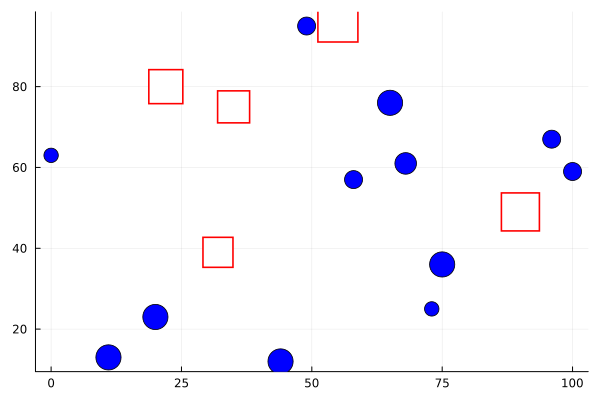

In [ ]:
DrawInstance()

Ahora sí estamos preparados para centrarnos en el modelo matemático:

In [ ]:
function UFLP0()
  model = Model(GLPK.Optimizer)
  @variable(model, y[1:n], Bin)
  @variable(model, x[1:n, 1:m]>=0 )
  @constraint(model, [i=1:n],       sum(x[i,:]) <= supply[i] * y[i]  )
  @constraint(model, [j=1:m],       sum(x[:,j]) >= demand[j]  )
  @constraint(model, [i=1:n, j=1:m],  x[i,j] <= demand[j] * y[i]  )
  @objective(model, Min,    fix'y + sum(cost .* x)    )
  optimize!(model)
  if termination_status(model)==OPTIMAL
    print("Optimal obj value: ", objective_value(model),"  = ",fix'value.(y)," + ",sum( cost .* value.(x) ))
    println("  Open facilities: ",value.(y))
#   DrawSolution()
    return objective_value(model)
  else
    println("infeasible")
    return -1
  end
end

UFLP0 (generic function with 2 methods)

In [ ]:
UFL0()

LoadError: ignored

El problema de localización descrito se diferencia del problema de transporte en cuanto incluye en el costo el usar o no un almacén. No importa cuántos clientes lo usen. Esta característica lo complica drásticamente. Pero se puede complicar incluso más si además exigimos que cualquier *cliente sea servido exclusivamente por un único almacén*. Para esto segundo conviene introducir una nueva variable $z_{ij}$ y el modelo matemático cambia como se describe en la siguiente celda:

In [ ]:
function UFLP1()
    model = Model(GLPK.Optimizer)
    @variable(model, y[1:n], Bin)
    @variable(model, z[1:n, 1:m], Bin)
    @constraint(model, [j=1:m],       sum(z[:,j]) == 1  )
    @constraint(model, [i=1:n, j=1:m],  z[i,j] <= y[i]  )
    @constraint(model, [i=1:n],       sum(demand[j]*z[i,j] for j=1:m) <= supply[i] * y[i]  )
    @objective(model, Min,    fix'y + sum(cost[i,j]*demand[j]*z[i,j] for i=1:n,j=1:m  ) )
    optimize!(model)
    if termination_status(model)==OPTIMAL
      print("Optimal obj value: ", objective_value(model),"  = ",fix'value.(y)," + ", sum( cost[i,j]*demand[j]*value.(z[i,j]) for i=1:n,j=1:m  ) )
      println("  Open facilities: ",value.(y))
  #   DrawSolution()
      return objective_value(model)
    else
      println("infeasible")
      return -1
    end
end


UFLP1 (generic function with 2 methods)

In [ ]:
UFLP1()

LoadError: ignored

Cuando el problema de localización no es factible porque $\sum_j d_j > \sum_i q_i$, arriba hemos sugerido reducir las demandas proporcionalmente. Notemos que la reducción propuesta hará factible el problema donde un cliente puede ser servido desde varias plantas, pero no necesariamente el problema donde un cliente debe ser servido desde una planta. El siguiente modelo calcula el mayor $p$ que garantiza factibilidad en este segundo problema:
$$
\begin{array}
\mbox{ Max } & p \\
&\sum_{i\in I} z_{ij} = 1 & j\in J\\
&z_{ij} \leq y_i & i \in I\\
&\sum_{j\in J} p d_j z_{ij} \leq q_i y_i & i\in I\\
&z_{ij}\in\{0,1\}& i\in I, j\in J\\
&y_i\in \{0,1\} & i\in I
\end{array}
$$
Observa que el modelo escrito es no-lineal debido a que $p$ y $z_{ij}$ son incógnitas y aparecen multiplicadas en una desigualdad. Una forma de eludir este inconveniente es:
$$
\begin{array}
\mbox{ Max } & p \\
&\sum_{i\in I} z_{ij} = 1 & j\in J\\
&z_{ij} \leq y_i & i \in I\\
&\sum_{j\in J} x_{ij} \leq q_i y_i & i\in I\\
&-\overline p d_j (1-z_{ij}) + p d_j \leq x_{ij} \leq p d_j  +\overline p d_j (1-z_{ij}) & i\in I,j\in J\\
&0\leq x_{ij} \leq \overline p d_j z_{ij}& i\in I, j\in J\\
&z_{ij}\in\{0,1\}& i\in I, j\in J\\
&y_i\in \{0,1\} & i\in I\\
&0\leq p \leq \overline p
\end{array}
$$
donde $\overline p=\sum_{i\in I}q_i / \sum_{j\in J}d_j$.


In [ ]:
function UFLPp()
    pmax = sum(supply)/sum(demand)
    @show pmax

    model = Model(Gurobi.Optimizer)
    @variable(model, x[1:n,1:m]>=0 )
    @variable(model, y[1:n], Bin)
    @variable(model, z[1:n, 1:m], Bin)
    @variable(model, 0 <= p <= pmax)
    @constraint(model, [j=1:m],        sum(z[:,j]) == 1  )
    @constraint(model, [i=1:n, j=1:m], z[i,j] <= y[i]  )
    @constraint(model, [i=1:n],        sum(x[i,:]) <= supply[i] * y[i]  )
    @constraint(model, [i=1:n, j=1:m],  - pmax * demand[j] * (1-z[i,j]) + p * demand[j] <= x[i,j] )
    @constraint(model, [i=1:n, j=1:m],    pmax * demand[j] * (1-z[i,j]) + p * demand[j] >= x[i,j] )
    @constraint(model, [i=1:n, j=1:m],    x[i,j] <= pmax * demand[j] * z[i,j] )
    @objective(model, Max, p )
    optimize!(model)
    return ( termination_status(model)==OPTIMAL ? objective_value(model) : -1 )
end

## Localización de Concentradores

Disponemos de $n$ localizaciones (por ejemplo, ciudades en el mundo) que desean enviarse un producto entre ellas (por ejemplo, cartas postales). Sea $N=\{1,\ldots,n\}$. Conocemos la demanda $d_{ij}$ de producto que se desea enviar desde $i$ hasta $j$. Cualquier envío debe enviarse primero directamente a una oficina que la clasifica y envía, o directamente a su destinatario, o directamente a otra oficina que la envía directamente a su destinatario. El problema es decidir dónde conviene localizar las oficinas, teniendo presente que instalar una oficina tiene un costo fijo y que no se quieren instalar más de $p$ oficinas. Se asume que se conoce el coste $c_{ij}$ desde $i$ hasta $j$. Dicho coste viene reducido por un factor conocido $\alpha$ cuando $i$ y $j$ son oficinas. Sea además $\pi$ el coste para el cliente por unidad enviada, y $\delta$ el coste para el cliente por unidad recibida. Asumimos que si un cliente envia varias unidades, todas deben ir primero a una oficina y no a varias, sin importar que dichas unidades vaya luego a destinos diferentes. También asumimos que las oficinas pueden gestionar cantidades ilimitadas de unidades.

In [ ]:
n = 50
N = 1:n

Random.seed!(1234)
d = rand(1:100,n,n)
c = rand(1:100,n,n)
f = rand(1:100,n)

O = sum(d,dims=1)
D = sum(d,dims=2)

p = 5
α = 0.2
χ = 2
δ = 3

3

Un primer modelo usa una variable $z_{ik}$ para decidir si el cliente $i$ está asignado o no a la oficina $k$. Cuando $z_{kk}=1$ se entiende que $k$ es oficina. Un primer modelo matemático es:
$$
\begin{array}
\mbox{ min } & \sum_{k\in N} f_k z_{kk} +
\sum_{i,k\in N} (\chi O_i + \delta D_i) c_{ik} x_{ik} +
\sum_{i,j,k,m\in N} \alpha d_{ij}c_{km} z_{ik}z_{jm} \\
&\sum_{k=\in N} z_{ik} = 1 & i\in N\\
&z_{ik} \leq z_{kk} & i,k\in N\\
&z_{ik} \in \{0,1\} & i,k\in N
\end{array}
$$
Este modelo tiene el inconveniente de tener un término cuadrático en su función objetivo. Veamos otro modelo que evita este inconveniente.

Una alternativa es introducir una nueva variable $x_{ijkm}$ que determina si la demanda que sale de $i$ para $j$ va primero por $k$ y luego por $m$. Se permite $k=m$ por si una demanda sólo pasa por una oficina. Entonces el modelo es:
$$
\begin{array}
\mbox{ min } & \sum_{k\in N} f_k z_{kk} +
\sum_{i,j,k,m\in N} g_{ijkm} x_{ijkm}\\
&\sum_{k\in N} z_{ik} = 1 & i\in N\\
&z_{ik} \leq z_{kk} & i,k\in N\\
&z_{ik} \in \{0,1\} & i,k\in N\\
&\sum_{m\in N} x_{ijkm} = z_{ik} & i,j,k\in N\\
&\sum_{k\in N} x_{ijkm} = z_{jm} & i,j,m\in N\\
&x_{ijkm} \geq 0 & i,j,k,m\in N
\end{array}
$$
donde $g_{ijkm} = d_{ij}(\chi c_{ik} + \alpha c_{km} + \delta c_{mj} ) $ representa el coste total del producto enviado desde $i$ a $j$ que va por las oficinas $k$ y $m$.

El modelo mostrado tiene muchas variables. Concretamente hay $O(n^4)$, que es un número enorme. Es posible un tercer modelo también lineal pero con menos variables. 

Una opción es introducir una nueva familia de variables $y_{km}$ que represente la cantidad de producto que va de la oficina $k$ a la oficina $m$:
$$
\begin{array}
\mbox{ min } & \sum_{k\in N} f_k z_{kk} +
\sum_{i,k\in N} (\chi O_i + \delta D_i) c_{ik} z_{ik} +
\sum_{k,m\in N} \alpha c_{km} y_{km} \\
&\sum_{k\in N} z_{ik} = 1 & i\in N\\
&z_{ik} \leq z_{kk} & i,k\in N\\
&z_{ik} \in \{0,1\} & i,k\in N\\
&y_{km} \geq \sum_{(i,j)\in K} d_{ij}(z_{ik}+z_{jm}-1)& k,m\in N , \; S\subseteq N\times N\\
&y_{ikm} \geq 0 & i,k,m\in N
\end{array}
$$
Esta formulación tiene un número $O(n^2)$ de variables y un número exponencial de restricciones. Esto último no es realmente un inconveniente, pero busquemos otro modelo con un número polinomial de restricciones.


Otra opción es introducir la nueva variable $y_{ikm}$ que indica la cantidad de demanda que sale de i y pasa primero por la oficina $k$ y luego por la oficina $m$.
$$
\begin{array}
\mbox{ min } & \sum_{k\in N} f_k z_{kk} +
\sum_{i,k\in N} (\chi O_i + \delta D_i) c_{ik} z_{ik} +
\sum_{i,k,m\in N} \alpha c_{km} y_{ikm} \\
&\sum_{k\in N} z_{ik} = 1 & i\in N\\
&z_{ik} \leq z_{kk} & i,k\in N\\
&z_{ik} \in \{0,1\} & i,k\in N\\
&\sum_{j\in N} d_{ij}z_{jk}+
\sum_{m\in N} y_{ikm} = \sum_{m\in N} y_{imk}+
O_i z_{ik} & i,k\in N\\
&y_{ikm} \geq 0 & i,k,m\in N
\end{array}
$$


In [ ]:
model = Model(GLPK.Optimizer)
@variable(model, z[1:n, 1:n], Bin)
@variable(model, y[1:n, 1:n, 1:n] >= 0)
@objective(model, Min, sum(f[k]*z[k,k] for k=1:n) + sum( (χ*O[i]+δ*D[i])*c[i,k]*z[i,k] for i=1:n,k=1:n) + sum(α*c[k,m]*y[i,k,m] for i=1:n,k=1:n,m=1:n) )
@constraint(model, [i=1:n], sum(z[i,k] for k=1:n) == 1 )
@constraint(model, [i=1:n,k=1:n], z[i,k] <= z[k,k] )
@constraint(model, [i=1:n,k=1:n], sum(d[i,j]*z[j,k] for j=1:n) + sum(y[i,k,m] for m=1:n)  == sum(y[i,m,k] for m=1:n) + O[i]*z[i,k]   )

undo_relax = relax_integrality(model);
optimize!(model)
println("LP val: $(objective_value(model))    Time=$(solve_time(model))  ")
undo_relax()
optimize!(model)
println("IP val: $(objective_value(model))    Time=$(solve_time(model)) ")

# Problema del Viajante de Comercio

Este problema es el más conocido dentro de la Optimización Combinatoria. Puedes encontrarlo en la [wikipedia](https://es.wikipedia.org/wiki/Problema_del_viajante). Existe incluso un [película](https://en.wikipedia.org/wiki/Travelling_Salesman_(2012_film)) que te recomiendo veas.

Dado un conjunto de ciudades y conocidas las distancias entre cualesquiera dos ciudades, el TSP busca determinar un tour que visite una y sólo una vez cada ciudad y con el menor coste total posible.

Hay dos versiones según se asuma que la distancia entre dos ciudades es simétrica o no. Por simplicidad en la exposición, en este cuaderno trabajaremos si dicha hipótesis (es decir, como si la distancia pudiese cambiar con el sentido en el que se recorra la carretera), aunque lo ilustremos visualmente sobre soluciones donde sí se tenga dicha hipóteis (porque el gráfico en la pantalla se comprende mejor).

Usaremos este importante problema de optimización para mostrar diferentes modelos matemáticos. Compararemos entre modelos y aprenderemos a conocer elementos que hacer que un modelo sea mejor que otro.

Comenzaremos describiendo 4 modelos matemáticos de tipo compacto, es decir, con números polinomiales (bajos) de variables y de restricciones.

In [ ]:
Pkg.add("LightGraphs")
Pkg.add("LightGraphsFlows")
using LightGraphs, LightGraphsFlows

   Resolving package versions...
   Installed ArnoldiMethod ─ v0.1.0
   Installed SimpleTraits ── v0.9.4
   Installed Inflate ─────── v0.1.3
   Installed LightGraphs ─── v1.3.5
    Updating `~/.julia/environments/v1.8/Project.toml`
  [093fc24a] + LightGraphs v1.3.5
    Updating `~/.julia/environments/v1.8/Manifest.toml`
⌅ [ec485272] + ArnoldiMethod v0.1.0
  [d25df0c9] + Inflate v0.1.3
  [093fc24a] + LightGraphs v1.3.5
  [699a6c99] + SimpleTraits v0.9.4
  [8ba89e20] + Distributed
  [1a1011a3] + SharedArrays
        Info Packages marked with ⌅ have new versions available but cannot be upgraded. To see why use `status --outdated -m`
Precompiling project...
  ✓ Inflate
  ✓ SimpleTraits
  ✓ ArnoldiMethod
  ✓ LightGraphs
  4 dependencies successfully precompiled in 7 seconds. 152 already precompiled.
   Resolving package versions...
   Installed LightGraphsFlows ─ v0.3.1
   Installed MathProgBase ───── v0.7.8
    Updating `~/.julia/environments/v1.8/Project.toml`
⌃ [2f5eb75a] + LightGraphsFl

In [ ]:
function readRandomInstance(N)
    Random.seed!(1234)
    coord = rand( 0:1000 , N, 2)
    cost  = zeros( Int32, N, N)
    for i=1:N, j=1:N
        cost[i,j]=round(sqrt((coord[i,1]-coord[j,1])^2+(coord[i,2]-coord[j,2])^2),digits=0)
    end
    return N,coord,cost
end

function ExtractTour(N, sol)
    i = 1     # Start at city 1 always
    tour = [i]  
    while true
        for j = 1:N
            if sol[i,j] > 0.5
                push!(tour, j)
                i = j
                break
            end
        end
        if i==1 break
        end
    end 
    return tour
end

function PlotTour(N, coord, sol)
    plt = Plots.plot()
    for i=1:N, j=1:N
        if sol[i,j] > 0.5
            Plots.plot!([coord[i,1], coord[j,1]], [coord[i,2], coord[j,2]]; legend = false)
        end
    end
    display(plt)
    return plt
end

PlotTour (generic function with 1 method)

Iniciamos creando unos datos aleatoriamente para luego plantear y resolver modelos del TSP sobre estos datos.

In [ ]:
N, coord,cost = readRandomInstance(20)

(20, [326 110; 549 491; … ; 997 701; 749 95], Int32[0 441 … 894 423; 441 0 … 495 444; … ; 894 495 … 0 655; 423 444 … 655 0])

## Modelos compactos

La siguiente celda contiene 4 modelos diferentes para el TSP. Estos modelos tienen un número polinomial de variables y restricciones, por lo que (en principio) pueden generarse por completo antes de resolverse.

In [ ]:
function CompactATSP(var)
    model = Model(GLPK.Optimizer)
#    set_silent(model)
#    set_time_limit_sec(model, 60.0)
    set_optimizer_attribute(model, "tm_lim", 60 * 1_000)
    set_optimizer_attribute(model, "msg_lev", GLPK.GLP_MSG_OFF)

    if var=='a'
        @variable(model, x[1:N,1:N,1:N], Bin)
        for i=1:N,k=1:N
            set_upper_bound(x[i,i,k], 0)
        end
        @objective(model, Min, sum(cost[i,j]*x[i,j,k] for i=1:N,j=1:N,k=1:N))
        @constraint(model, [i=1:N], sum(x[i,j,k] for k=1:N,j=1:N) == 1)
        @constraint(model, [j=1:N], sum(x[i,j,k] for i=1:N,k=1:N) == 1)
        @constraint(model, [k=1:N], sum(x[i,j,k] for i=1:N,j=1:N) == 1)
        @constraint(model, sum(x[1,j,1] for j=2:N) == 1)
        @constraint(model, sum(x[j,1,N] for j=2:N) == 1)
        @constraint(model, [i=2:N,k=2:N], sum(x[j,i,k-1] for j=1:N) == sum(x[i,j,k] for j=1:N) )

    else
        @variable(model, x[1:N,1:N], Bin)
        for i=1:N
            set_upper_bound(x[i,i], 0)
        end
        @objective(model, Min, sum(cost .* x))
        @constraint(model, [i=1:N], sum(x[i,:]) == 1)
        @constraint(model, [i=1:N], sum(x[:,i]) == 1)
        if var=='u'
            @variable(model, u[2:N]>=0 )
            for i=2:N,j=2:N 
              if i!=j
                @constraint(model, u[j] >= u[i] + x[i,j] - (N-2)*(1-x[i,j]) + (N-3)*x[j,i] )
              end
            end

        elseif var=='v'
            @variable(model, v[2:N,2:N]>=0 )
            for i=2:N
                set_upper_bound(v[i,i], 0)
            end
            @constraint(model, [i=2:N,j=i+1:N], v[i,j]+v[j,i]<=1 )
            for i=2:N,j=2:N,k=2:N
              if i!=j && i!=k && j!=k
                @constraint(model, v[i,j]+v[j,k]<=v[i,k]+1 )
              end
            end
            for i=2:N,j=2:N 
              if i!=j
                @constraint(model, v[i,j] >= x[i,j] )
              end
            end

        elseif var=='f'
            @variable(model, f[1:N,1:N]>=0 )
            for i=1:N
                set_upper_bound(f[i,i], 0)
            end
            @constraint(model, [i=2:N], sum( f[j,i]-f[i,j] for j=1:N if i!=j) >=1 )
            for i=1:N,j=1:N 
              if i!=j
                @constraint(model, f[i,j] <= (N-1)*x[i,j] )
              end
            end

        else
            println("model of type $(var) is undefined")
        end
    end

    undo_relax = relax_integrality(model);
    optimize!(model)
    println("LP val: $(objective_value(model))    Time=$(solve_time(model))  ")
    undo_relax()
    optimize!(model)
    print("IP val: $(objective_value(model))    Time=$(solve_time(model))   Solution: ")

    if var=='a'
       sol = zeros( Float64, N, N)
       xval = value.(x)
       for i=1:N,j=1:N
           sol[i,j] = sum( xval[i,j,:] )
       end
    else
       sol = value.(x)
    end
    println( ExtractTour(N,sol) )
    PlotTour(N, coord, sol)
    println("")
end

CompactATSP (generic function with 1 method)

LP val: 3911.5964461070835    Time=0.18148589134216309  
IP val: 4191.0    Time=44.850955963134766   Solution: [1, 6, 18, 20, 7, 4, 12, 8, 17, 19, 10, 16, 11, 2, 15, 9, 5, 14, 3, 13, 1]


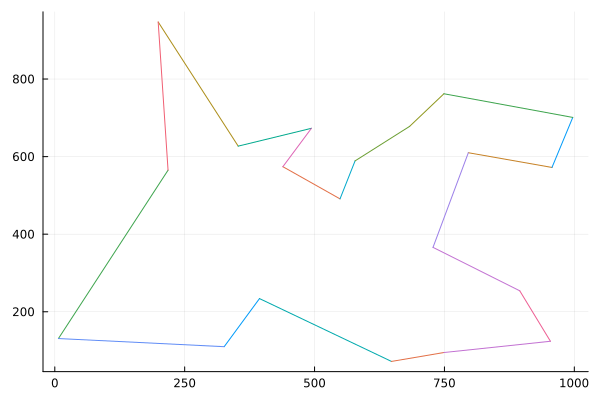

In [ ]:
CompactATSP('a')

LP val: 3973.0000000000005    Time=0.003899097442626953  
IP val: 4191.0    Time=0.34833407402038574   Solution: [1, 13, 3, 14, 5, 9, 15, 2, 11, 16, 10, 19, 17, 8, 12, 4, 7, 20, 18, 6, 1]


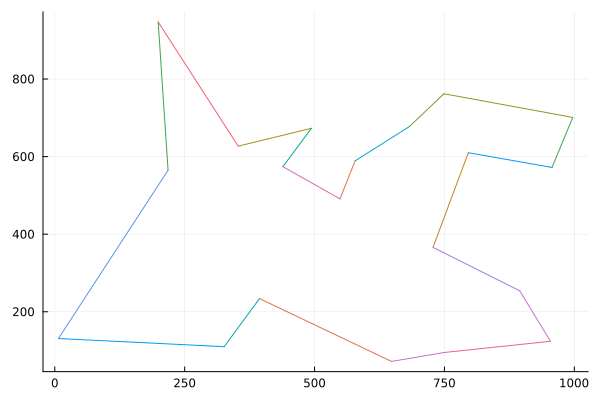

In [ ]:
CompactATSP('u')

LP val: 3973.000000000001    Time=0.15160107612609863  
IP val: 4191.0    Time=7.301681995391846   Solution: [1, 6, 18, 20, 7, 4, 12, 8, 17, 19, 10, 16, 11, 2, 15, 9, 5, 14, 3, 13, 1]


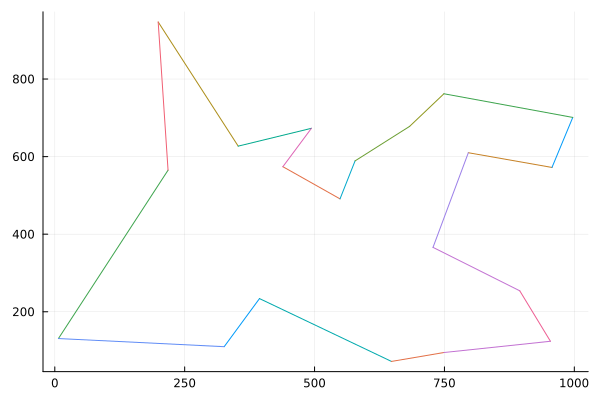

In [ ]:
CompactATSP('v')

LP val: 3859.473684210527    Time=0.006054878234863281  
IP val: 4191.0    Time=2.8512511253356934   Solution: [1, 6, 18, 20, 7, 4, 12, 8, 17, 19, 10, 16, 11, 2, 15, 9, 5, 14, 3, 13, 1]


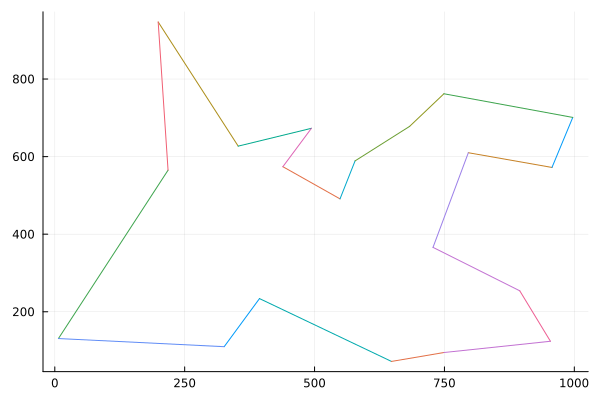

In [ ]:
CompactATSP('f')

## Modelos dinámicos

La siguiente celda muestra un modelo que genera dinámicamente restricciones eliminando las soluciones enteras inválidas mediante
$ \sum_{i\in S,j\in S} x_{ij} \leq |S|-1 $ para todo $S\subset V$. Claramento hay un número exponencial de estas restricciones y no tiene sentido generarlas todas para luego resolver un modelo compacto. Mejor ir generándolas dinámicamente a medida que se necesitan.

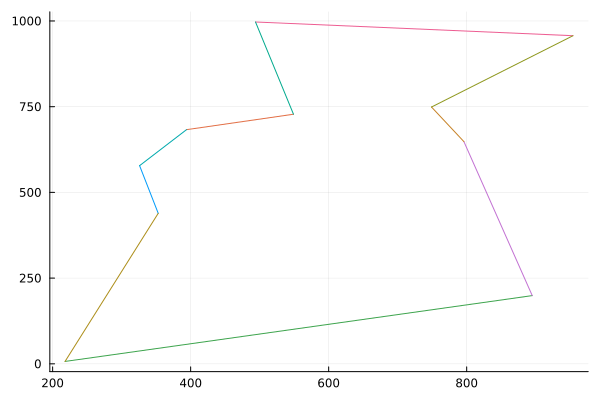

Lower bound : 3185.0
Iterations=1  Cuts=0   Time=0.0003769397735595703
Optval: 3185.0    ;   Solution: [1, 5, 3, 4, 8, 10, 7, 9, 2, 6, 1]


In [ ]:
function CuttingPlane(model,x)
    tcuts = 0
    iterations = 1
    Ttime = 0
    while true
        optimize!(model)
        Ttime += solve_time(model)
        
        xval = JuMP.value.(x)
        PlotTour( N, coord, xval)
        println("Lower bound : ",objective_value(model))

        G = SimpleDiGraph( Edge.([ (i,j) for i=1:N,j=1:N if xval[i,j]>0.5 ]) )
        Components = connected_components(G)
        if length(Components)==1
            break
        end
        @constraint(model, [S in Components], sum(x[S,S]) <= length(S)-1 )   
        tcuts += length(Components)
        iterations += 1
    end
    println("Iterations=$(iterations)  Cuts=$(tcuts)   Time=$(Ttime)")  
end

function SolveATSPcut()
    model = Model(GLPK.Optimizer)

    @variable(model, x[1:N,1:N], Bin)
    for i in 1:N
        set_upper_bound(x[i,i], 0)
    end

    @objective(model, Min, sum(cost .* x))
    @constraint(model, [i=1:N], sum(x[i,:]) == 1)
    @constraint(model, [i=1:N], sum(x[:,i]) == 1)
    @constraint(model, [i=1:N,j=i+1:N], x[i,j]+x[j,i] <= 1)

    CuttingPlane(model,x)

    print("Optval: $(objective_value(model))    ;   Solution: ")
    println( ExtractTour(N, value.(x)) )
end

SolveATSPcut()

Por último, veamos el modelo más eficiente, que consiste en introducir los mismos cortes pero no sólo sobre soluciones enteras inválidas sino también sobre soluciones fraccionarias que las necesiten. Esta metodología de resolución se conoce genéricamente como *Branch-and-Cut*.

In [ ]:
N, coord,cost = readRandomInstance(50)

(50, [326 442; 549 885; … ; 854 492; 706 933], Int32[0 496 … 530 621; 496 0 … 497 164; … ; 530 497 … 0 465; 621 164 … 465 0])

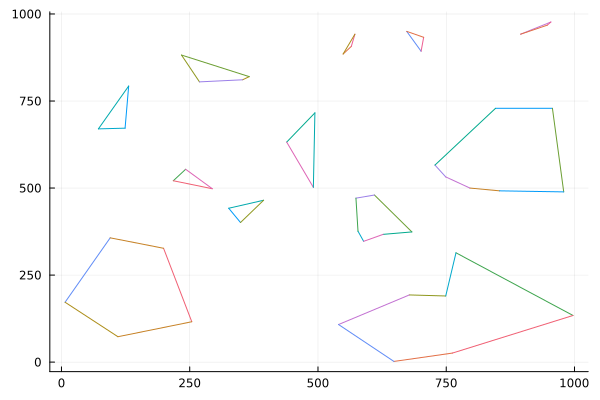

Lower bound : 5114.0


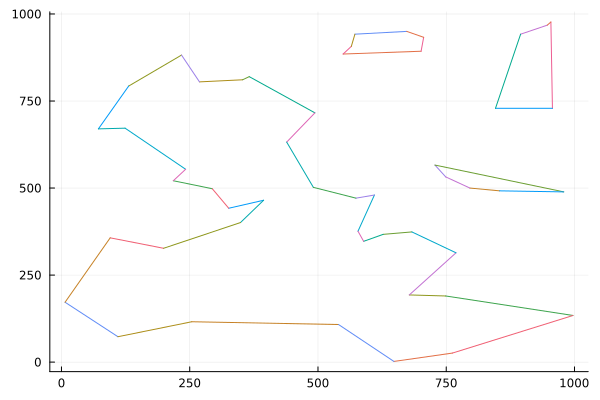

Lower bound : 5530.0


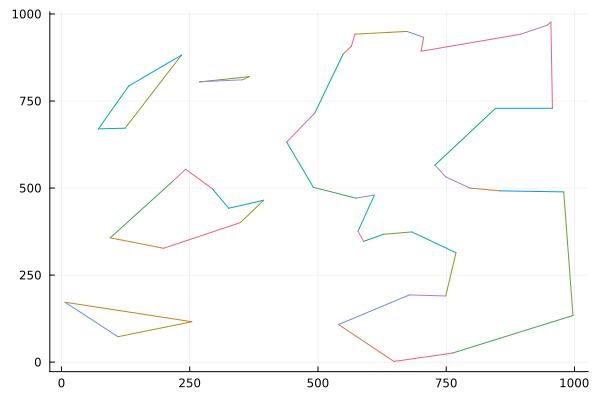

Lower bound : 5595.0


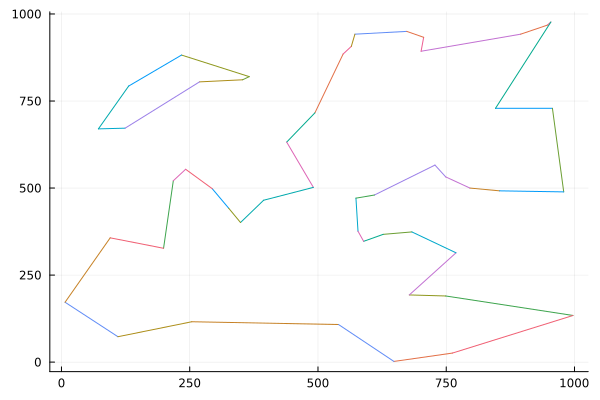

Lower bound : 5610.0


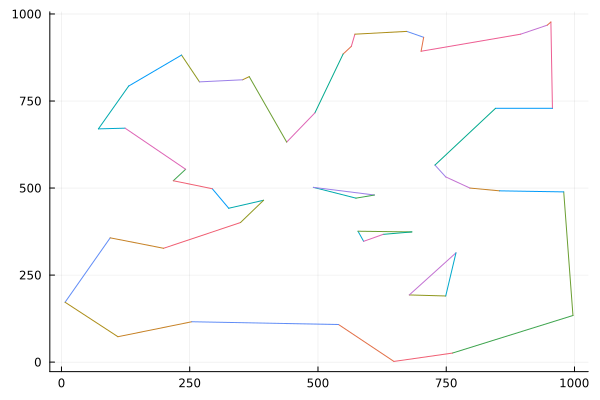

Lower bound : 5611.0


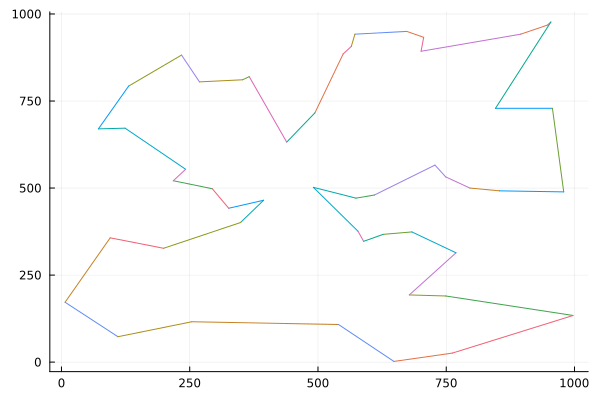

Lower bound : 5624.0
Iterations=6  Cuts=27   Time=2.4453399181365967
Optval: 5624.0    ;   Solution: [1, 6, 42, 14, 40, 13, 21, 24, 45, 18, 30, 19, 10, 36, 43, 16, 25, 31, 11, 22, 35, 28, 12, 20, 8, 49, 48, 17, 41, 7, 34, 4, 39, 50, 29, 37, 23, 2, 9, 15, 32, 5, 44, 26, 33, 38, 27, 47, 3, 46, 1]


In [ ]:
SolveATSPcut()

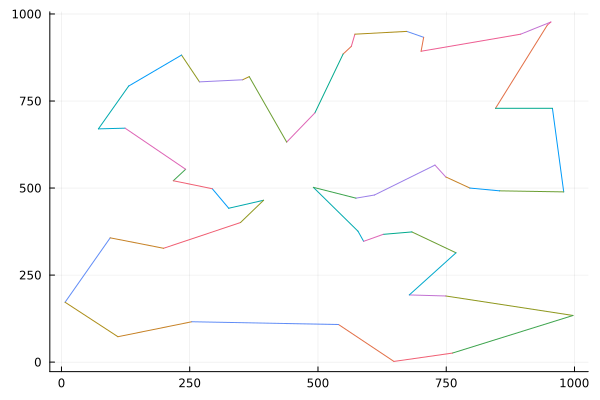

Iterations=67  Cuts=177   Time=6.696629047393799  
Optval: 5624.0    ;   Solution: [1, 46, 3, 47, 27, 38, 33, 26, 44, 5, 32, 15, 9, 2, 23, 37, 29, 50, 39, 4, 7, 34, 41, 17, 48, 49, 8, 20, 12, 28, 35, 22, 11, 31, 25, 16, 43, 36, 10, 19, 30, 18, 45, 24, 21, 13, 40, 14, 42, 6, 1]


In [ ]:
function SEC(xval, x)
    EPS = 1e-5
    VIOLA = 1e-4
    cuts = []

    G = SimpleDiGraph( Edge.([ (i,j) for i=1:N,j=1:N if xval[i,j]>EPS ]) )
    Components = connected_components(G)
    if length(Components)>1
        for S in Components
            push!(cuts,@build_constraint(sum(x[S,S]) <= length(S)-1))
        end
        return cuts
    end
    
    if ne(G)==N
        return []
    end

    for i = 2:N
        fval, fsol, labels = maximum_flow(G,1,i,xval,algorithm=BoykovKolmogorovAlgorithm())
        if fval < 1-VIOLA
            S = Set()
            for j = 1:N
                if labels[j] == 1
                    push!(S, j);
                end
            end
            push!(cuts,@build_constraint(sum(x[u,v] for u in S, v in S) <= length(S)-1))
        end
    end
    return cuts
end

function BranchAndCut(model,x)

    function my_lazy_callback_function(cb_data)
#        status = callback_node_status(cb_data, model)
#        println("STATUS=$(status)")
        xval = callback_value.(Ref(cb_data), x)
        cuts = SEC(xval, x)
        for cut in cuts
            MOI.submit(model, MOI.LazyConstraint(cb_data), cut)
        end
        iterations += 1
        tcuts += length(cuts)
    end
        
    function my_usercutCallback_function(cb_data)
        xval = callback_value.(Ref(cb_data), x)
        cuts = SEC(xval, x)
        for cut in cuts
            MOI.submit(model, MOI.UserCut(cb_data), cut)
        end
        iterations += 1
        tcuts += length(cuts)
    end    

    MOI.set(model, MOI.LazyConstraintCallback(), my_lazy_callback_function)
#    MOI.set(model, MOI.UserCutCallback(), my_usercutCallback_function)

    tcuts = 0
    iterations = 1
    optimize!(model)
    PlotTour( N, coord, value.(x) )
    println("Iterations=$(iterations)  Cuts=$(tcuts)   Time=$(solve_time(model))  ")  
end

function SolveATSPbc()
    model = Model(GLPK.Optimizer)
    set_silent(model)

    @variable(model, x[1:N,1:N], Bin)
    for i in 1:N
        set_upper_bound(x[i,i], 0)
    end

    @objective(model, Min, sum(cost .* x))
    @constraint(model, [i=1:N], sum(x[i,:]) == 1)
    @constraint(model, [i=1:N], sum(x[:,i]) == 1)
    @constraint(model, [i=1:N,j=i+1:N], x[i,j]+x[j,i] <= 1)

    BranchAndCut(model,x)

    print("Optval: $(objective_value(model))    ;   Solution: ")
    println( ExtractTour(N, value.(x)) )
end

SolveATSPbc()